## Estimate Home Values in Zillow

#### Goals:

Your customer is the zillow data science team. state your goals as if you were delivering this to zillow. They have asked for something from you and you are basically communicating in a more concise way, and very clearly, the goals as you understand them and as you have taken and acted upon through your research.

Add outline of project here

#### Import
Import the necessay libraries needed to create a baseline model and then predict home values. Add libraries as needed.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.linear_model import LinearRegression
from math import sqrt
import warnings
warnings.filterwarnings("ignore")

import env
import wrangle
import split_scale
import features

In this step, I loaded cleaned Zillow data from my wrangle.py file and explored it for a better understanding of what I am working with. The clean up proccess eliminated null values and changed data types to types more appropriate for the column contents.

In [2]:
df = wrangle.wrangle_zillow()
df.shape

(14892, 10)

Summary Statistics of data

In [3]:
df.describe()

,bedroom,bathroom,lot_size,square_feet,tax_amount,home_value,property_id,fips
count,14892.000000,14892.000000,1.489200e+04,14892.000000,14892.000000,1.489200e+04,14892.0,14892.000000
mean,3.316143,2.324302,1.053110e+04,1938.497045,6564.370992,5.396460e+05,261.0,6049.448429
std,0.926831,1.014254,2.937957e+04,992.488089,8428.010576,7.290735e+05,0.0,21.272489
min,1.000000,1.000000,5.940000e+02,300.000000,51.260000,1.050400e+04,261.0,6037.000000
25%,3.000000,2.000000,5.594000e+03,1276.000000,2710.622500,1.991870e+05,261.0,6037.000000
50%,3.000000,2.000000,6.869000e+03,1678.000000,4762.040000,3.847785e+05,261.0,6037.000000
75%,4.000000,3.000000,8.865250e+03,2342.250000,7637.557500,6.435572e+05,261.0,6059.000000
max,11.000000,11.000000,1.323788e+06,15450.000000,276797.830000,2.385837e+07,261.0,6111.000000


Summary of data frame

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14892 entries, 0 to 14892
Data columns (total 10 columns):
bedroom             14892 non-null int64
bathroom            14892 non-null float64
lot_size            14892 non-null int64
square_feet         14892 non-null int64
tax_amount          14892 non-null float64
home_value          14892 non-null int64
property_id         14892 non-null int64
property_type       14892 non-null object
fips                14892 non-null int64
transaction_date    14892 non-null object
dtypes: float64(2), int64(6), object(2)
memory usage: 1.2+ MB


#### Splitting the Data
I used a split function I created, located in a split_scale.py file to split the data into two peices, train and test. The training data will be 80% of the data and the remaining 20% will be for the test data. I set a random seed at '123'.

In [5]:
train, test = split_scale.split_my_data(df, train_pct=.80, random_state=123)
train.head(), test.head()

(       bedroom  bathroom  lot_size  square_feet  tax_amount  home_value  \
 7040         2       3.0      9376         2353    13560.29     1121784   
 4866         3       1.0      5061         1085     2581.75      194062   
 2280         3       2.0      7588         1873     4301.71      339756   
 12524        4       3.0      7969         2082     4443.44      376676   
 10726        4       3.5      8000         4364     8876.72      875357   
 
        property_id              property_type  fips transaction_date  
 7040           261  Single Family Residential  6037       2017-06-19  
 4866           261  Single Family Residential  6037       2017-06-02  
 2280           261  Single Family Residential  6037       2017-05-16  
 12524          261  Single Family Residential  6059       2017-06-16  
 10726          261  Single Family Residential  6059       2017-05-19  ,
        bedroom  bathroom  lot_size  square_feet  tax_amount  home_value  \
 13487        5       3.0      60

I then split the train and test pieces even further to establish an 'x' and 'y' variable for both. To establish a baseline, I chose to look at three features in particular, the bedroom count, the bathroom count, and the total square footage of the house. I am assigning the home value as my target variable, since that is what I am looking to predict. 

In [6]:
x_train = train[['bedroom', 'bathroom', 'square_feet']]
y_train = train[['home_value']]
x_test = train[['bedroom', 'bathroom', 'square_feet']]
y_test = train[['home_value']]
print(x_train.head())
print(y_train.head())

       bedroom  bathroom  square_feet
7040         2       3.0         2353
4866         3       1.0         1085
2280         3       2.0         1873
12524        4       3.0         2082
10726        4       3.5         4364
       home_value
7040      1121784
4866       194062
2280       339756
12524      376676
10726      875357


#### Scale the data using Standard Scale
I am using the Standard Scaler function from the split_scale.py file to scale the data so the difference between square feet and the bedroom/bathroom count can work from the same scale. I am only scaling the x_train and x_test features.

In [7]:
scaler, x_train, x_test = split_scale.standard_scaler(x_train, x_test)
scaler

StandardScaler(copy=True, with_mean=True, with_std=True)

In [8]:
x_train.head()

,bedroom,bathroom,square_feet
7040,-1.410430,0.661645,0.406343
4866,-0.338366,-1.299218,-0.853773
2280,-0.338366,-0.318786,-0.070673
12524,0.733697,0.661645,0.137028
10726,0.733697,1.151861,2.404839


Using a modeling function, I create a new data frame, 'predictions', to establish a baseline model by taking the mean of my target, home value. I then plug my scaled data into a Linear Regression model within the function and that is added to the newly created data frame. The data frame then outputs the target predictions.

In [9]:
def modeling_function(x_train, x_test, y_train, y_test):
    predictions=pd.DataFrame({'actual_value':y_train.home_value}).reset_index(drop=True)
    predictions['baseline'] = y_train.mean()[0]    
    
    # model 1
    model1 = LinearRegression()
    model1.fit(x_train, y_train)
    model1_predictions = model1.predict(x_train)
    predictions['model1'] = model1_predictions
    
    return predictions

In [10]:
predictions = modeling_function(x_train, x_test, y_train, y_test)

In [11]:
predictions.head()

,actual_value,baseline,model1
0,1121784,544122.62948,9.833761e+05
1,194062,544122.62948,9.831026e+04
2,339756,544122.62948,5.410204e+05
3,376676,544122.62948,5.412151e+05
4,875357,544122.62948,1.705229e+06


#### Evaluate scaled model compared to the baseline model.

In [12]:
MSE_base = mean_squared_error(predictions.actual_value, predictions.baseline)
SSE_base = MSE_base * len(predictions.actual_value)
RMSE_base = sqrt(MSE_base)
r2_base = r2_score(predictions.actual_value, predictions.baseline)
print(MSE_base, SSE_base, RMSE_base, r2_base)

575225329640.1548 6852659352003164.0 758436.1078167064 0.0


#### Model Error

In [13]:
MSE_1 = mean_squared_error(predictions.actual_value, predictions.model1)
SSE_1 = MSE_1 * len(predictions.actual_value)
RMSE_1 = sqrt(MSE_1)
r2_1 = r2_score(predictions.actual_value, predictions.model1)
print(MSE_1,SSE_1,RMSE_1,r2_1)

356640202824.1915 4248654736244593.5 597193.6058132167 0.37999913347471004


I created a data frame to show the differences between the baseline model and scaled model to see side-by-side.

In [14]:
df_eval = pd.DataFrame(np.array(['SSE','MSE','RMSE', 'R^2']), columns=['metric'])
df_eval['baseline_error'] = np.array([SSE_base, MSE_base, RMSE_base, r2_base])
df_eval['model_error'] = np.array([SSE_1, MSE_1, RMSE_1, r2_1])
df_eval['error_delta'] = df_eval.model_error - df_eval.baseline_error
df_eval

,metric,baseline_error,model_error,error_delta
0,SSE,6.852659e+15,4.248655e+15,-2.604005e+15
1,MSE,5.752253e+11,3.566402e+11,-2.185851e+11
2,RMSE,7.584361e+05,5.971936e+05,-1.612425e+05
3,R^2,0.000000e+00,3.799991e-01,3.799991e-01


#### Exploration in Visualization
move this up under scale

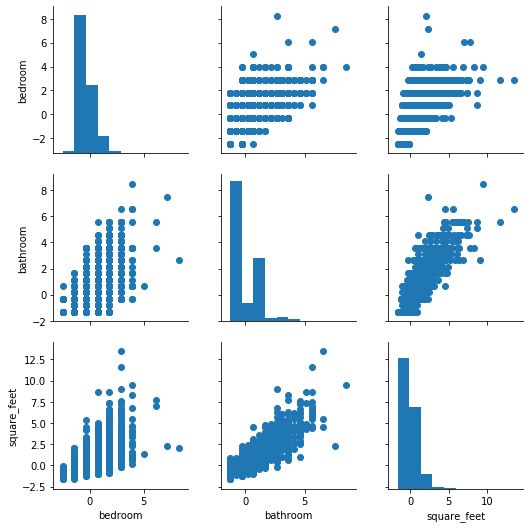

In [15]:
g = sns.PairGrid(x_train)
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter)

scaler lookup
vis after scale thought process with scaler
conclusions after evaluate

#### County Distribution

In [16]:
df['tax_rate'] = df['tax_amount']/df['home_value']

In [17]:
df.head()

,bedroom,bathroom,lot_size,square_feet,tax_amount,home_value,property_id,property_type,fips,transaction_date,tax_rate
0,3,2.0,8284,1458,2319.90,136104,261,Single Family Residential,6037,2017-06-23,0.017045
1,2,1.0,6707,1421,543.69,35606,261,Single Family Residential,6037,2017-06-30,0.015270
2,3,2.0,7300,1650,7673.19,614000,261,Single Family Residential,6037,2017-06-01,0.012497
3,2,1.0,2908,693,3267.47,274237,261,Single Family Residential,6037,2017-06-29,0.011915
4,3,2.0,6050,1108,5990.50,486866,261,Single Family Residential,6037,2017-05-17,0.012304


t-test and correlation
finish distribution
